In [ ]:
!pip install tensorflow keras numpy pillow kagglehub

Downloading Dataset

In [ ]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1


Folder partition

In [ ]:
import os

# Verify dataset path
dataset_path = "/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/PlantVillage"
print("Dataset path:", dataset_path)

# List all folders in the dataset
folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
print("Folders in dataset:", folders)

# Check for non-disease folders
non_disease_folders = [f for f in folders if not any(char in f for char in ['___', '__'])]
print("Non-disease folders:", non_disease_folders)

Dataset path: /root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/PlantVillage
Folders in dataset: ['Tomato_healthy', 'Potato___Early_blight', 'train', 'Potato___Late_blight', 'Tomato_Septoria_leaf_spot', 'Tomato_Early_blight', 'Tomato__Tomato_mosaic_virus', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Late_blight', 'Pepper__bell___healthy', 'Tomato__Target_Spot', 'Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'validation', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Pepper__bell___Bacterial_spot']
Non-disease folders: ['Tomato_healthy', 'train', 'Tomato_Septoria_leaf_spot', 'Tomato_Early_blight', 'Tomato_Bacterial_spot', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'validation', 'Tomato_Spider_mites_Two_spotted_spider_mite']


Train_Test_Split

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
dataset_path = "/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/PlantVillage"
train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'validation')

# Create train and validation directories
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

# Split ratio (80% train, 20% validation)
split_ratio = 0.8

# Iterate through each disease folder
for disease_folder in os.listdir(dataset_path):
    disease_path = os.path.join(dataset_path, disease_folder)

    # Skip non-directories
    if not os.path.isdir(disease_path):
        print(f"Skipping non-directory: {disease_folder}")
        continue

    # Get all images in the disease folder
    images = [img for img in os.listdir(disease_path)
              if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Skip folders with no images
    if len(images) == 0:
        print(f"Warning: No images found in {disease_folder}, skipping...")
        continue

    # Split images into train and validation sets
    train_images, val_images = train_test_split(images, train_size=split_ratio, random_state=42)

    # Create disease subfolders in train and validation directories
    os.makedirs(os.path.join(train_path, disease_folder), exist_ok=True)
    os.makedirs(os.path.join(val_path, disease_folder), exist_ok=True)

    # Copy images to train folder
    for img in train_images:
        src = os.path.join(disease_path, img)
        dst = os.path.join(train_path, disease_folder, img)
        shutil.copy(src, dst)

    # Copy images to validation folder
    for img in val_images:
        src = os.path.join(disease_path, img)
        dst = os.path.join(val_path, disease_folder, img)
        shutil.copy(src, dst)

    print(f"Processed {disease_folder}: {len(images)} images (Train: {len(train_images)}, Val: {len(val_images)})")

print("Dataset split completed successfully!")

Processed Tomato_healthy: 1591 images (Train: 1272, Val: 319)
Processed Potato___Early_blight: 1000 images (Train: 800, Val: 200)
Processed Potato___Late_blight: 1000 images (Train: 800, Val: 200)
Processed Tomato_Septoria_leaf_spot: 1771 images (Train: 1416, Val: 355)
Processed Tomato_Early_blight: 1000 images (Train: 800, Val: 200)
Processed Tomato__Tomato_mosaic_virus: 373 images (Train: 298, Val: 75)
Processed Potato___healthy: 152 images (Train: 121, Val: 31)
Processed Tomato_Bacterial_spot: 2127 images (Train: 1701, Val: 426)
Processed Tomato_Late_blight: 1909 images (Train: 1527, Val: 382)
Processed Pepper__bell___healthy: 1478 images (Train: 1182, Val: 296)
Processed Tomato__Target_Spot: 1404 images (Train: 1123, Val: 281)
Processed Tomato_Leaf_Mold: 952 images (Train: 761, Val: 191)
Processed Tomato__Tomato_YellowLeaf__Curl_Virus: 3208 images (Train: 2566, Val: 642)
Processed Tomato_Spider_mites_Two_spotted_spider_mite: 1676 images (Train: 1340, Val: 336)
Processed Pepper__bel

Data Generators

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import os

# Verify GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Configuration
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20  # Start with fewer epochs for testing
TRAIN_DATA_DIR = '/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/PlantVillage/train'
VAL_DATA_DIR = '/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/PlantVillage/validation'

# Data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
print("Creating training generator...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("\nCreating validation generator...")
validation_generator = val_datagen.flow_from_directory(
    VAL_DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Model architecture using Transfer Learning
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    ModelCheckpoint(
        '/content/drive/MyDrive/best_model (3).h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]



GPU Available: []
Creating training generator...
Found 16504 images belonging to 15 classes.

Creating validation generator...
Found 4134 images belonging to 15 classes.


Model_Training

In [ ]:
# Training
print("\nStarting training...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

# Save class indices
np.save('class_indices.npy', train_generator.class_indices)
print("\nTraining completed! Model saved as best_model.h5")

Evaluation

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/130 ━━━━━━━━━━━━━━━━━━━━ 13:20 6s/step - accuracy: 0.2517 - loss: 2.8214

KeyboardInterrupt: 

REMEDIES

In [ ]:
REMEDIES = {
    'Potato___healthy': {
        'description': 'Healthy potato plant',
        'remedies': [
            'No action needed',
            'Maintain good growing conditions'
        ]
    },
    'Potato___Early_blight': {
        'description': 'Fungal disease causing dark spots on leaves',
        'remedies': [
            'Remove and destroy infected leaves',
            'Apply copper-based fungicides',
            'Practice crop rotation'
        ]
    },
    'Tomato_Septoria_leaf_spot': {
        'description': 'Fungal disease causing small dark spots with light centers on leaves',
        'remedies': [
            'Remove affected leaves',
            'Use fungicides like chlorothalonil',
            'Avoid overhead watering'
        ]
    },
    'Tomato__Tomato_mosaic_virus': {
        'description': 'Viral disease causing mottled, mosaic-like leaf patterns',
        'remedies': [
            'Remove and destroy infected plants',
            'Control aphids and other insect vectors',
            'Use resistant tomato varieties'
        ]
    },
    'Pepper__bell___healthy': {
        'description': 'Healthy bell pepper plant',
        'remedies': [
            'No action needed',
            'Ensure proper watering and nutrition'
        ]
    },
    'Tomato_Spider_mites_Two_spotted_spider_mite': {
        'description': 'Tiny pests causing yellowing and webbing on leaves',
        'remedies': [
            'Spray plants with neem oil or insecticidal soap',
            'Introduce predatory mites',
            'Increase humidity to deter mites'
        ]
    },
    'Tomato__Target_Spot': {
        'description': 'Fungal disease causing brown spots with yellow halos on leaves',
        'remedies': [
            'Apply copper-based fungicides',
            'Remove infected leaves',
            'Improve air circulation around plants'
        ]
    },
    'Tomato_healthy': {
        'description': 'Healthy tomato plant',
        'remedies': [
            'No action needed',
            'Maintain good growing conditions'
        ]
    },
    'Pepper__bell___Bacterial_spot': {
        'description': 'Bacterial disease causing water-soaked spots on leaves and fruit',
        'remedies': [
            'Remove infected plants',
            'Apply copper sprays',
            'Use disease-resistant varieties'
        ]
    },
    'Tomato_Late_blight': {
        'description': 'Serious fungal disease causing brown, water-soaked lesions',
        'remedies': [
            'Remove and destroy affected plants',
            'Apply fungicides containing chlorothalonil',
            'Ensure proper air circulation'
        ]
    },
    'Potato___Late_blight': {
        'description': 'Severe fungal disease causing dark lesions on leaves and tubers',
        'remedies': [
            'Use resistant potato varieties',
            'Apply fungicides like chlorothalonil or copper-based sprays',
            'Avoid excessive moisture'
        ]
    },
    'Tomato_Early_blight': {
        'description': 'Fungal disease causing dark, concentric rings on leaves',
        'remedies': [
            'Apply fungicides such as copper-based sprays',
            'Remove affected leaves',
            'Use mulch to prevent soil splash'
        ]
    },
    'Tomato__Tomato_YellowLeaf__Curl_Virus': {
        'description': 'Viral disease causing leaf curling and yellowing',
        'remedies': [
            'Remove and destroy infected plants',
            'Control whiteflies, the main vector',
            'Use virus-resistant tomato varieties'
        ]
    },
    'Tomato_Bacterial_spot': {
        'description': 'Bacterial disease causing small, water-soaked spots on leaves and fruit',
        'remedies': [
            'Remove affected plants',
            'Apply copper-based sprays',
            'Use disease-free seeds'
        ]
    },
    'Tomato_Leaf_Mold': {
        'description': 'Fungal disease causing yellowing and mold growth on leaves',
        'remedies': [
            'Improve air circulation',
            'Apply fungicides like copper-based sprays',
            'Avoid overhead watering'
        ]
    }
}


Importing libraries

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

Loading pretrained model

In [ ]:
model = load_model("/content/drive/MyDrive/best_model (3).h5")  # Replace with your file path


Predicting user uploaded image

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


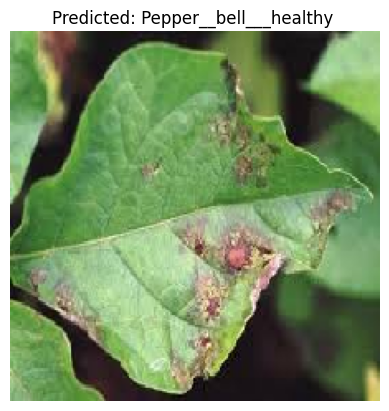


Recommended Remedies:
Description: Healthy bell pepper plant
Remedies:
1. No action needed
2. Ensure proper watering and nutrition
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


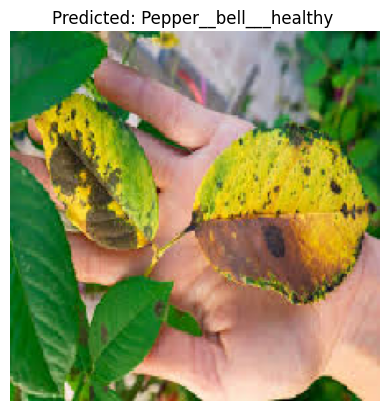


Recommended Remedies:
Description: Healthy bell pepper plant
Remedies:
1. No action needed
2. Ensure proper watering and nutrition
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


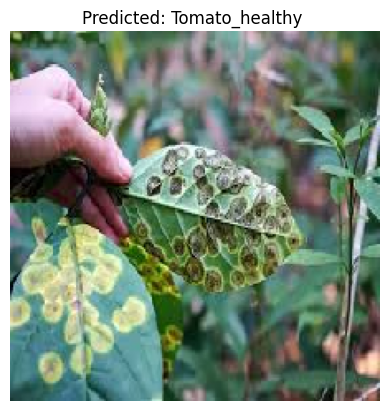


Recommended Remedies:
Description: Healthy tomato plant
Remedies:
1. No action needed
2. Maintain good growing conditions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


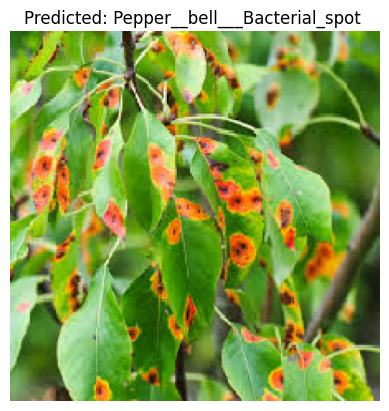


Recommended Remedies:
Description: Bacterial disease causing water-soaked spots on leaves and fruit
Remedies:
1. Remove infected plants
2. Apply copper sprays
3. Use disease-resistant varieties
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


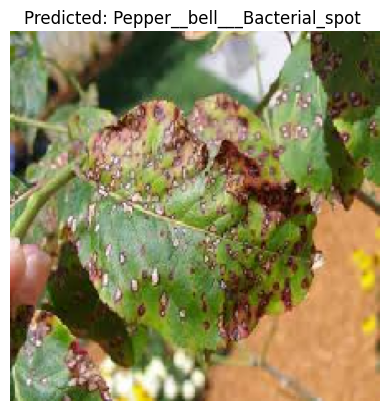


Recommended Remedies:
Description: Bacterial disease causing water-soaked spots on leaves and fruit
Remedies:
1. Remove infected plants
2. Apply copper sprays
3. Use disease-resistant varieties


In [ ]:
def predict_image(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    pred = model.predict(img_array)
    class_idx = np.argmax(pred[0])
    class_name = list(train_generator.class_indices.keys())[class_idx]
    confidence = np.max(pred[0])

    # Get remedies
    remedy = REMEDIES.get(class_name, {
        'description': 'No information available',
        'remedies': ['Consult with an agricultural expert']
    })

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted: {class_name} ")  #({confidence:.2%})
    plt.axis('off')
    plt.show()

    # Print remedies
    print("\nRecommended Remedies:")
    print(f"Description: {remedy['description']}")
    print("Remedies:")
    for i, r in enumerate(remedy['remedies'], 1):
        print(f"{i}. {r}")

# Test with multiple images
predict_image('/content/download.jpg')
predict_image('/content/download (1).jpg')
predict_image('/content/download (2).jpg')
predict_image('/content/download (3).jpg')
predict_image('/content/download (4).jpg')